In [1]:
from datasets import load_from_disk

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

import argparse
import easydict

import math

import utils

from utils import Utils, Logger

In [32]:
import argparse
import easydict

args = easydict.EasyDict({'type': 'gan',
                        'stage' : 1,
                        'stage1_gen_path': '',
                        'lr': 0.001,
                        'l1_coef': 50,
                        'l2_coef': 100,
                        'noise_dim': 200,
                        'embed_dim': 200,
                        'projected_embed_dim': 2048,
                        'cls': True,
                        'save_path':'Result',
                        'batch_size': 128,
                        'ngf': 64,
                        'ndf': 64,
                        'num_workers':7,
                        'image_size': 64,
                        'num_channels': 3,
                        'epochs': 1000})

In [33]:
from datasets import load_from_disk
import numpy as np

In [34]:
reloaded_dataset = load_from_disk("PreProcessedData3")
reloaded_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'company', 'content', 'description', 'textwithoutcompany', 'fulltext', 'textwithoutcompanycombined'],
        num_rows: 33034
    })
    test: Dataset({
        features: ['image', 'company', 'content', 'description', 'textwithoutcompany', 'fulltext', 'textwithoutcompanycombined'],
        num_rows: 14158
    })
})

In [35]:
from collections import Counter
import torch
import torch.nn as nn

In [36]:
merged_sentance = ""
for data in reloaded_dataset["train"]:
    merged_sentance = merged_sentance + data["textwithoutcompanycombined"]+" "
print(len(merged_sentance))
for data in reloaded_dataset["test"]:
    merged_sentance = merged_sentance + data["textwithoutcompanycombined"]+" "
print(len(merged_sentance))

690114
984594


In [37]:
words = merged_sentance.split(' ')
 
# create a dictionary
vocab = Counter(words) 
vocab = sorted(vocab, key=vocab.get, reverse=True)
vocab_size = len(vocab)
 
# create a word to index dictionary from our Vocab dictionary
word2idx = {word: ind for ind, word in enumerate(vocab, 1)} 
idx2word = {ind: word for ind, word in enumerate(vocab, 1)}

In [38]:
e_dim = 20
torch.manual_seed(108)
emb = nn.Embedding(vocab_size, e_dim)

In [39]:
def get_encoded_sentences(sentance):
    words = sentance.split(' ')
    encoded_words = [word2idx[word] for word in words]
    return encoded_words

def get_decoded_sentences(encoded_words):
    sentance = ' '.join([idx2word[idx] for idx in encoded_words])
    return sentance

In [49]:
testtext = 'woman man holding hands'
encoded_sentences = get_encoded_sentences(testtext)
encoded_sentences = np.pad(encoded_sentences, [(0, 10-len(encoded_sentences))], mode='constant', constant_values=0)
word_vectors = emb(torch.LongTensor(encoded_sentences))
word_vectors = word_vectors.reshape(word_vectors.shape[0]*word_vectors.shape[1]).detach().numpy()

In [50]:
word_vectors

array([-1.1474894e+00, -4.1638729e-01, -1.4853164e+00,  1.0850017e+00,
       -2.2135925e+00,  3.1873617e-01, -5.3673053e-01,  1.0872558e+00,
        3.0153263e-01,  4.0867624e-01,  3.7414219e-02,  3.0022106e-01,
       -2.6253048e-01,  8.4488195e-01,  1.5109459e-01,  7.7006936e-01,
       -1.4467649e-01, -1.6484622e+00,  5.1223898e-01,  7.5517184e-01,
       -1.0527424e+00,  5.0792909e-01, -6.1527294e-01, -5.1569355e-01,
       -7.2788358e-01, -1.2218233e+00,  1.6580805e+00, -6.1811656e-01,
       -1.8767943e+00,  1.3310223e+00,  4.3200305e-01, -1.6278013e+00,
        1.0160360e+00, -4.1486952e-01, -1.3289210e+00,  2.5416508e+00,
        1.3796252e-02, -9.2079204e-01, -1.4813539e+00, -9.8601961e-01,
       -7.5554568e-04, -1.1273984e+00, -1.3774681e+00,  1.2807808e-02,
        9.3518674e-01,  1.7019741e-01,  2.0493486e+00, -3.4191179e-01,
        1.7672888e+00, -8.7568149e-02,  5.0226337e-01,  5.6978840e-01,
       -1.5931857e+00, -4.0861481e-01,  2.9879400e-01, -8.7463282e-02,
      

In [51]:
class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.image_size = args.image_size
        self.num_channels = args.num_channels
        self.noise_dim = args.noise_dim
        self.embed_dim = args.embed_dim
        self.projected_embed_dim = args.projected_embed_dim
        self.latent_dim = self.noise_dim + (self.projected_embed_dim * 2)
        self.ngf = args.ngf
        
        self.projection = nn.Sequential(
            nn.Linear(in_features=self.embed_dim, out_features=self.projected_embed_dim),
            nn.BatchNorm1d(num_features=self.projected_embed_dim),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Linear(in_features=self.projected_embed_dim, out_features=self.projected_embed_dim*2),
            nn.BatchNorm1d(num_features=self.projected_embed_dim*2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
            )

        self.netG = nn.Sequential(
            nn.ConvTranspose2d(self.latent_dim, self.ngf * 16, 2, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(self.ngf * 16, self.ngf * 8, 3, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(self.ngf * 8, self.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(self.ngf * 4, self.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(self.ngf * 2,self.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(self.ngf, self.num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
             # state size. (num_channels) x 64 x 64
            )


    def forward(self, embed_vector, z):

        projected_embed = self.projection(embed_vector).unsqueeze(2).unsqueeze(3)
        latent_vector = torch.cat([projected_embed, z], 1)
        output = self.netG(latent_vector)

        return output

In [52]:
class generator2(nn.Module):
    def __init__(self,stage1_gen):
        super(generator2, self).__init__()
        self.image_size = args.image_size
        self.num_channels = args.num_channels
        self.noise_dim = args.noise_dim
        self.embed_dim = args.embed_dim
        self.projected_embed_dim = args.projected_embed_dim
        self.latent_dim = self.noise_dim + self.projected_embed_dim
        self.stage2_latent_dim = self.image_size*self.image_size*self.num_channels + self.noise_dim + self.projected_embed_dim
        self.ngf = args.ngf
        
        self.stage1_gen = stage1_gen
        # Freezing the stage 1 generator:
        for param in self.stage1_gen.parameters():
            param.requires_grad = False
            
            
        self.encoder = nn.Sequential(
            nn.ConvTranspose2d(3, 128, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True), #? Paper: leaky, code: relu
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.projection = nn.Sequential(
            nn.Linear(in_features=self.embed_dim, out_features=self.projected_embed_dim),
            nn.BatchNorm1d(num_features=self.projected_embed_dim),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
            )

        self.netG = nn.Sequential(
            nn.ConvTranspose2d(self.projected_embed_dim+512, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(512,256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(256,128, 3, 1, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128,64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(64, self.num_channels, 3, 1, 1, bias=False),
            nn.Tanh()
             # state size. (num_channels) x 64 x 64
            )
            


    def forward(self, embed_vector, noise):
        
        stage1_img = self.stage1_gen(embed_vector, noise)
        stage1_img = stage1_img.detach()
        
        #(batch_size,512,16,16)
        encoded_img = self.encoder(stage1_img)
        
        #(batch_size,128,16,16)
        projected_embed = self.projection(embed_vector).unsqueeze(2).unsqueeze(3).repeat(1, 1, 16, 16)
        
        #(batch_size,512,16,16)
        latent_vector = torch.cat([encoded_img,projected_embed], 1)
        
        #(batch_size,3,64,64)
        output = self.netG(latent_vector)

        return output

In [53]:
def predict(emd, gen):
    right_embed = Variable(torch.LongTensor(np.array(emd, dtype="float32")).float())

    # Train the generator
    noise = Variable(torch.randn(len(emd),200))
    noise = noise.view(len(emd),200, 1, 1)
    
    fake_images = gen(right_embed, noise)

    return fake_images

In [54]:
def load_generator(stage,path):
    if stage == 1:
        gen = torch.load(path)
        state_dict = {}
        for key in gen:
            state_dict["".join(key.split("module.")[1:])] = gen[key]
        stage1_generator = generator()
        stage1_generator.load_state_dict(state_dict)
        
        return stage1_generator
    else:
        gen = torch.load(path)
        state_dict = {}
        for key in gen:
            state_dict["".join(key.split("module.")[1:])] = gen[key]
        stage1_generator = generator()
        stage2_generator = generator2(stage1_generator)
        stage2_generator.load_state_dict(state_dict)
        
        return stage2_generator

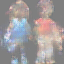

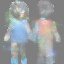

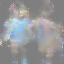

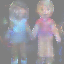

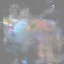

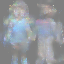

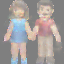

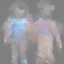

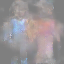

In [55]:
epochs = ["100","200","300","400","500","600","700","800","900"]
folderdir = "/home/emoji_with_text/results-20240922-071227" 
for epoch in epochs:
    path = os.path.join(folderdir,epoch,"gen.pth")
    stage1_generator = load_generator(1,path)
    stage1_generator.eval()
    image = predict([word_vectors]*2,stage1_generator)
    im = Image.fromarray(image[1].data.mul_(127.5).add_(127.5).byte().permute(1, 2, 0).numpy())
    im.show()

stage1_generator = load_generator(1,'/home/emoji_with_text/results-20240918-153314/400/gen.pth')